# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, last, when, sum, mean, col, ceil, struct
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, LongType, DoubleType

from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt
import re

In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify") \
        .getOrCreate()
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# specify file path of the dataset
sparkify_data = "mini_sparkify_event_data.json"

In [4]:
# read json file
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# number of records in the dataset
size_orig = df.count()
print("The dataset has {} entries.".format(size_orig))

The dataset has 286500 entries.


In [6]:
# print the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# helper function for more convenience
def printCleandSize(size_clean, size_orig=size_orig):
    print("Dataset size after cleaning process: {} - removed {} entries".format(size_clean, size_orig - size_clean))

In [8]:
# Drop NA-values in the user defined columns. 
'''
Values where NA-values must be prevented:
- userId -> identifying the user
- page -> which page was accessed: e.g. downgrade/upgrade/next song:
- registration: the date of the registration 
- ts -> play-time: needed for analyzing the user activity during the day 
- level -> free/paid: needed for analyzing the churn rate
- status -> HTTP status codes: check if user is unsatisfied with Sparkify's availability 
- method -> HTTP request type: check if user is unsatisfied with Sparkify's availability
- gender -> check if there is a different behaviour for different gender
- sessionId -> assures the session was valid

usefull but not necessary relevant:
- auth -> "Cancalled / Logged In"
- firstName -> first name of te user
- lastName -> last name of the user
- location -> user geographical location
- userAgent -> difference between Win/Mac users
- itemInSession

Depending in the page event NA-valus in the follwing columns are acceptable:
- song -> name of the played song
- artist -> name of the artist 
- length -> length of the song (do not remove NA's here or the column page only contains "next page")
'''
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "method", "page", "ts", 
                                            "registration", "level", "userAgent", "method",
                                            "status"])
                           
size_clean = df_clean.count()
printCleandSize(size_clean)

Dataset size after cleaning process: 278154 - removed 8346 entries


In [9]:
# cleaning the gender column - assuming the null values can be either null or a other gender
# later this groups will be converted into numerical values
df_clean = df_clean.fillna("null/other", subset=["gender"])
df_clean.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [10]:
# check if after droping the NA-values there are still some invalid values
df_clean.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [11]:
# filter userIds with an empty string
df_clean = df_clean.filter(df_clean["userId"] != "")
printCleandSize(df_clean.count())

Dataset size after cleaning process: 278154 - removed 8346 entries


In [12]:
# user defined function to extract the play hour from the timestamp
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
# create the a new column "hour" this holds the hour when a user interacted with the system
df_clean = df_clean.withColumn("hour", get_hour(df.ts))

In [13]:
# side effect - the invalid usernames matched with the null/other values in the gender
df_clean.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary Analysis
The following part covers a basic analysis of Sparkify's user data.

In [14]:
# get the number of records
total_records = df_clean.count()
print("The dataset contains {} records.".format(total_records))

The dataset contains 278154 records.


In [15]:
# number of users
num_users = df_clean.select("userId").dropDuplicates().count()
print("The dataset contains {} users.".format(num_users))

The dataset contains 225 users.


#### User Groups (paid and unpaid memberships)
In this section the difference between paid and unpaid memberhips are shown. Since the users can change its membership status over time here all entries of the dataset are used.

In [16]:
# get membership data
pd_user_level = df_clean.groupby("level").count().toPandas()
pd_user_level

,level,count
0,free,55721
1,paid,222433


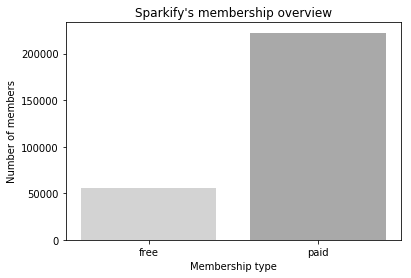

In [17]:
# plot memberhsip data
plt.figure();
plt.bar(pd_user_level.level.values, pd_user_level["count"], color=["lightgray", "darkgray"]);
plt.xlabel("Membership type");
plt.ylabel("Number of members");
plt.title("Sparkify's membership overview");

In [18]:
# calculate the percentages
free_percentage = pd_user_level["count"][0] / total_records
paid_percentage = 1 - free_percentage
print("Membership overview:"+
      "\n free: {:.2f}% ({})\n paid: {:.2f}% ({})".format(free_percentage, pd_user_level["count"][0], 
                                                          paid_percentage, pd_user_level["count"][1]))

Membership overview:
 free: 0.20% (55721)
 paid: 0.80% (222433)


#### User groups: gender
Are Sparkify's user equally distributed between all genders:

In [19]:
# get Sparkify users grouped by their gender
pd_gender = df_clean.groupby("gender").count().toPandas()
pd_gender.gender = pd_gender.gender.apply(lambda x: "female" if x == "F" else "male")

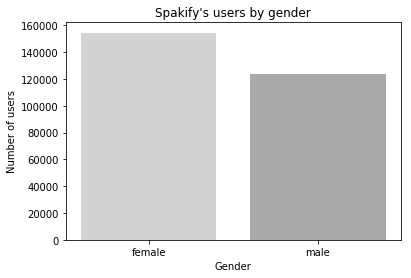

In [20]:
plt.figure();
plt.bar(pd_gender["gender"], pd_gender["count"], color=["lightgray", "darkgray"]);
plt.ylabel("Number of users");
plt.xlabel("Gender");
plt.title("Spakify's users by gender");

In [21]:
# percentage of female users
female_users = pd_gender["count"][0]/ total_records
female_users

0.55572812183179099

In [22]:
# percentage of male users
male_users = pd_gender["count"][1] / total_records
male_users

0.44427187816820896

In [23]:
# difference between female and male users
female_users - male_users

0.11145624366358203

The amount of female users are a bit higher (+ 11%) than the amount of male users.

#### Playtime over the day 
Discover the playtime over the day in respect to different groups:
* all users
* gender
* payed / unpaid

In [24]:
pd_playtime_all = df_clean.groupby("hour").count().sort("hour").toPandas()

In [25]:
pd_playtime_paid = df_clean.where("level == 'paid'").groupby("hour").count().sort("hour").toPandas()

In [26]:
pd_playtime_unpaid = df_clean.where("level != 'paid'").groupby("hour").count().sort("hour").toPandas()

In [27]:
pd_playtime_men = df_clean.where("gender == 'M'").groupby("hour").count().sort("hour").toPandas()

In [28]:
pd_playtime_female = df_clean.where("gender == 'F'").groupby("hour").count().sort("hour").toPandas()

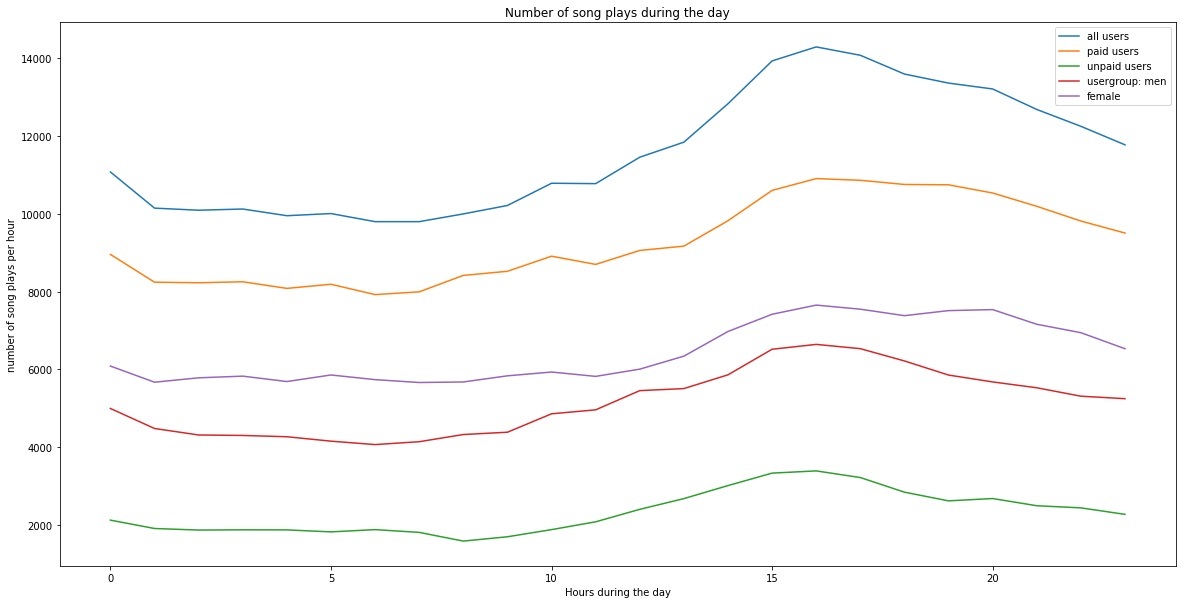

In [29]:
plt.figure(figsize=[20,10]);
plt.plot(pd_playtime_all["count"], label="all users");
plt.plot(pd_playtime_paid["count"], label="paid users");
plt.plot(pd_playtime_unpaid["count"], label="unpaid users");
plt.plot(pd_playtime_men["count"], label="usergroup: men");
plt.plot(pd_playtime_female["count"], label="female")
plt.xlabel("Hours during the day");
plt.ylabel("number of song plays per hour");
plt.title("Number of song plays during the day")
plt.legend();

#### Memberhship downgrades/upgrades
Exploring the membership up- and downgrades.

In [30]:
# count page event for each entry in the log file
df_clean.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [31]:
# number of downgrades
num_downgrades = df_clean.where("page = 'Submit Downgrade'").count()
num_downgrades_unique =df_clean.where("page = 'Submit Downgrade'").dropDuplicates().count()
print("The total number of downgrades is {} from {} different users".format(num_downgrades,
                                                                            num_downgrades_unique))

The total number of downgrades is 63 from 63 different users


In [32]:
# number of upgrades
num_upgrades = df_clean.where("page = 'Submit Upgrade'").count()
num_upgrades_unique =df_clean.where("page = 'Submit Upgrade'").dropDuplicates().count()
print("The total number of upgrades is {} from {} different users".format(num_upgrades,
                                                                          num_upgrades_unique))

The total number of upgrades is 159 from 159 different users


#### Location
This section covers a quick look at the location of Sparkify's users.

In [33]:
# use only the last two characters from the location indicating the state
split_location = udf(lambda x: re.split(" ", x)[-1])

In [34]:
pd_states = df_clean.dropDuplicates(["userId"]).withColumn("state", split_location(df_clean.location)).groupby("state").count().toPandas()

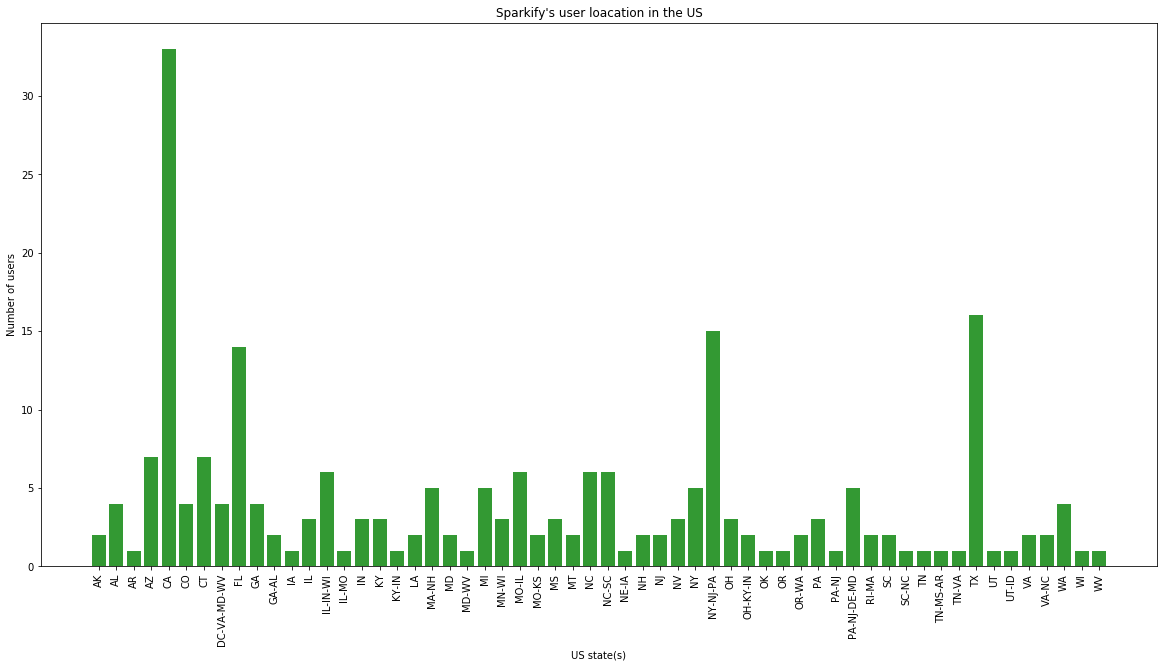

In [35]:
plt.figure(figsize=[20,10]);
plt.bar(pd_states.state, pd_states["count"], color="green", alpha=0.8);
plt.xlabel("US state(s)");
plt.ylabel("Number of users");
plt.title("Sparkify's user loacation in the US");
plt.xticks(rotation=90);

In [36]:
pd_states["count"].describe()

count    58.00000
mean      3.87931
std       5.06130
min       1.00000
25%       1.00000
50%       2.00000
75%       4.00000
max      33.00000
Name: count, dtype: float64

The users declared 58 different locations in the US - some location consits of several US states. Are are three areas with an higher user occurence.
* California on the west coast
* East coast area: New York, New Jersy and Pennsylvania
* South states with Texas and Florida

#### Artist and song
Most played artist and song:

In [37]:
# most played artists
df_clean.where(col("artist").isNotNull()).groupby("artist").count().sort("count", ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



In [38]:
# get the most played songs
df_clean.where(col("song").isNotNull()).groupby("song").count().sort("count", ascending=False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



In [39]:
# get the artist of the most played song
df_clean.select(["artist", "song"]).filter(df_clean.song.like("You're The One")).dropDuplicates().show()

+--------------------+--------------+
|              artist|          song|
+--------------------+--------------+
|                 SWV|You're The One|
|       Dwight Yoakam|You're The One|
|      The Black Keys|You're The One|
|Daedelus Featurin...|You're The One|
|Blood_ Sweat & Tears|You're The One|
|         Buddy Holly|You're The One|
|          The Vogues|You're The One|
+--------------------+--------------+



There are a lot of entries without an artist or song title, more precisely 50046 entries. These entries represent the page event except "Next song"

In [40]:
# number of page events where the artist and song are null
num_page_event = total_records - df_clean.filter(df_clean.artist.isNotNull()).count()
num_page_event

50046

In [41]:
# number of page events where the artist is not null
num_artist_events = df.dropna(how = "any", subset = ["artist"]).groupby("page").count().head()[1]
num_artist_events

228108

In [42]:
# check if the artist and page events sum up to total record number -> true
num_artist_events + num_page_event == total_records

True

#### Technical Issuses
Take a look how often there are technical proplems on the Sparify platform - based on the http status codes

In [43]:
pd_http_status = df_clean.groupby("status").count().toPandas()
pd_http_status

,status,count
0,307,23184
1,404,252
2,200,254718


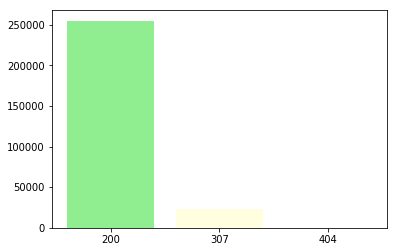

In [44]:
plt.figure();
plt.bar(["307", "404", "200"] ,pd_http_status["count"], color=["lightyellow", "red", "lightgreen"]);

In [45]:
print("Percentage of HTTP 404 Erros: {:.10f}".format(pd_http_status["count"][1]/ total_records))

Percentage of HTTP 404 Erros: 0.0009059730


Result: There is no need to care about technical issues. It seems that sparkify is a stable platform.

#### Registration time

In [46]:
get_year = udf(lambda x: datetime.fromtimestamp(x / 1000.0).year, IntegerType())
# create the a new column "hour" this holds the hour when a user interacted with the system
df_clean.withColumn("year", get_year(df_clean.registration)).groupby("year").count().show()

+----+------+
|year| count|
+----+------+
|2018|278154|
+----+------+



In [47]:
get_month = udf(lambda x: datetime.fromtimestamp(x / 1000).month, IntegerType())
get_day = udf(lambda x: datetime.fromtimestamp(x / 1000).day, IntegerType())

df_register = df_clean.withColumn("month", get_month(df_clean.registration))
df_register = df_register.withColumn("day", get_day(df_register.registration))
pd_reg_date = df_register.groupby(["month", "day"]).count().sort(["month", "day"]).toPandas()

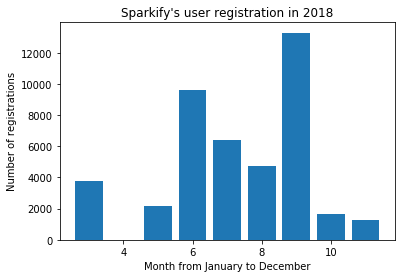

In [48]:
plt.figure();
plt.bar(pd_reg_date.month, pd_reg_date["count"]);
plt.xlabel("Month from January to December");
plt.ylabel("Number of registrations");
plt.title("Sparkify's user registration in 2018");

### Define Churn-Rate

In [49]:
# user defined function for set a churn indicator
get_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [50]:
# create new column churn
df_churn = df_clean.withColumn("churnEvent", get_churn(df_clean.page))

In [51]:
# number of cancellations
num_cancellation = df_churn.where("churnEvent = 1").dropDuplicates(["userId"]).count()

In [52]:
# calc churn rate
churn_rate = num_cancellation / num_users
print("The churn rate is at {:.3}%".format(churn_rate))

The churn rate is at 0.231%


In [53]:
# create window with userId - this is needed to extract the churn users
user_window = Window.partitionBy("userId")

In [54]:
# create a new column churn, where a unique churn value is assigned to each user 
df_churn = df_churn.withColumn("churn", F.max("churnEvent").over(user_window))

In [55]:
# get users grouped by churn
df_churn.dropDuplicates(["userid"]).groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



#### Downgrade

In [56]:
# user defined function for indicating a downgrade event
get_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())

In [57]:
# create temporary downgradeEvent column
df_churn = df_churn.withColumn("downgradeEvent", get_downgrade(df_churn.page)) 

In [58]:
# create new column downgrade 
df_churn = df_churn.withColumn("downgrade", F.max("downgradeEvent").over(user_window))

In [59]:
# drop temporary columns
df_churn = df_churn.drop(*["downgradeEvent", "churnEvent"])

In [60]:
# show how many users have downgraded their account from paid to unpaid
df_churn.dropDuplicates(["userId"]).groupby("downgrade").count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|        1|  154|
|        0|   71|
+---------+-----+



### Data exploration

#### Churn in level (paid/unpaid)

In [61]:
# show the account level (paid/unpaid) regarding the churn rate
df_churn.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



#### Churn in gender

In [62]:
# show the gender of the users grouped by churn
df_churn.dropDuplicates(["userId"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



#### Churn in user authentication 

In [63]:
# check if the churn users were logged in 
df_churn.dropDuplicates(["userId"]).groupby(["churn", "auth"]).count().sort("churn").show()

+-----+---------+-----+
|churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



#### Churn in location

In [64]:
# get user location grouped by chrun
pd_states_churn = df_churn.withColumn("state", split_location(df_clean.location))\
                          .dropDuplicates(["userId"]).groupby(["churn", "state"])\
                          .count().sort("churn").toPandas()

In [65]:
# unstack grouped variables for plotting the data
pd_states_plot = pd_states_churn.groupby(["state", "churn"]).sum().unstack().fillna(0)

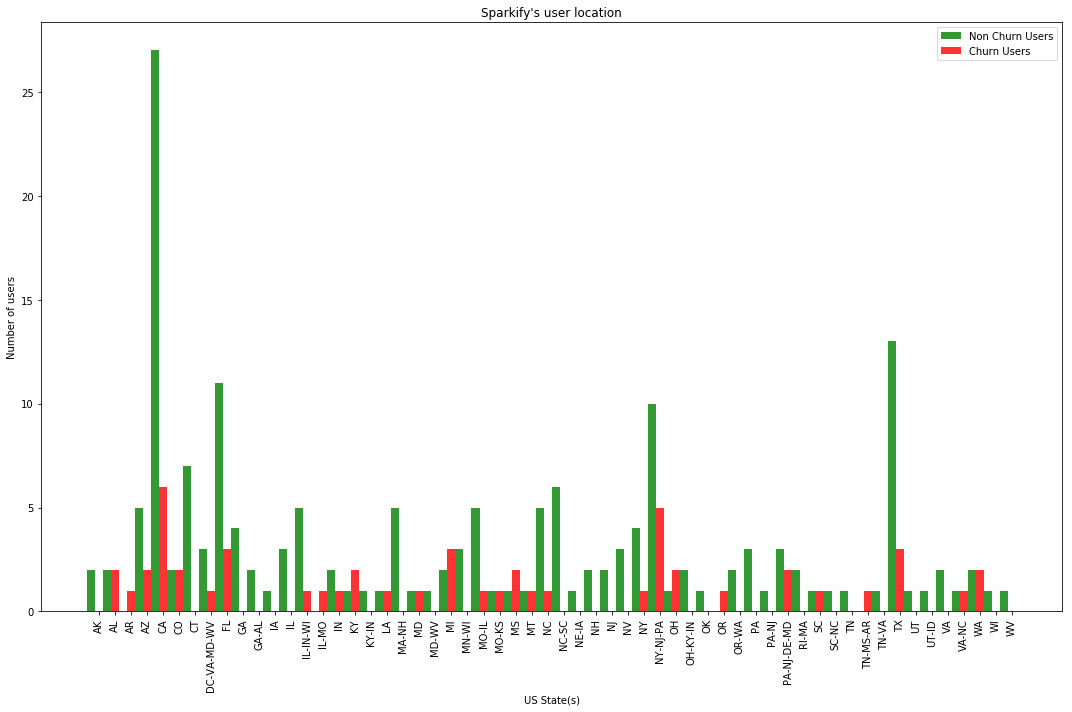

In [66]:
# create plot

# get required data
n_groups = pd_states_plot.shape[0]
user_state_churn = pd_states_plot["count"][1]
user_state = pd_states_plot["count"][0]
index_labels = pd_states_plot.index

# create plot
fig, ax = plt.subplots(figsize=[15,10])
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.bar(index, user_state, bar_width, alpha=opacity, color="green", label="Non Churn Users")
plt.bar(index + bar_width, user_state_churn, bar_width, alpha=opacity, color="red", label="Churn Users")
plt.xlabel("US State(s)")
plt.ylabel("Number of users")
plt.title("Sparkify's user location")
plt.xticks(index + bar_width, index_labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

#### Time between registration and unsubscribe request

In [67]:
# user defined function of calculating difference of two timestamps
udf_time = udf(lambda x: (x[1] - x[0]) if x[0] < x[1] else 0, IntegerType())

In [68]:
# add new column "churntime" -> hours between registration and confirmed cancellation
df_churn_time = df_churn.where("page = 'Cancellation Confirmation'").select(["userId", "registration", "ts"])\
                        .withColumn("churntime", udf_time(struct('registration', 'ts')))\
                        .withColumn("churntime", F.abs(F.ceil(col("churntime")/1000/60/60))).drop("ts")

In [69]:
# add the chruntime to matching users
df_churn = df_churn.join(df_churn_time, df_churn.userId == df_churn_time.userId, how='left')\
                   .select(df_churn["*"], df_churn_time["churntime"])

In [70]:
# calculate descriptives
df_churn.dropDuplicates(["userID"]).select("churntime").describe().show()

+-------+------------------+
|summary|         churntime|
+-------+------------------+
|  count|                52|
|   mean| 307.1730769230769|
| stddev|162.56000052515708|
|    min|                 2|
|    max|               563|
+-------+------------------+



In [71]:
# fill NA chruntime values after looking at the desciptives
df_churn = df_churn.fillna(0, subset=["churntime"])

The average churn time is 307.17 hours, which equals about 12.8 days. The longest churn time is only 2 houers where in contrast the longest duration is about 23.45 days.  

#### Playtime

In [72]:
# calculate playtime in minutes grouped by user churn
df_churn.where(df_churn.length.isNotNull()).groupby("length", "churn").count()\
.withColumn("time", (df_churn.length * col("count"))/60).groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 9195|
|    0|14336|
+-----+-----+



In [73]:
print("Total playtime for churn users: {:.2f} hours.".format(9195 / 60))
print("Total playtime for non-churn users: {:.2f} hours.".format(14336 / 60))

Total playtime for churn users: 153.25 hours.
Total playtime for non-churn users: 238.93 hours.


#### Page Roll Advert

In [74]:
df_churn.where("page = 'Roll Advert'").groupby(["page", "churn"]).count().show()

+-----------+-----+-----+
|       page|churn|count|
+-----------+-----+-----+
|Roll Advert|    1|  967|
|Roll Advert|    0| 2966|
+-----------+-----+-----+



#### Number of "Next Song" events

In [75]:
df_churn.where("page = 'NextSong'").select(["page", "churn"]).groupby(["page", "churn"]).count().show()

+--------+-----+------+
|    page|churn| count|
+--------+-----+------+
|NextSong|    0|191714|
|NextSong|    1| 36394|
+--------+-----+------+



#### Number of added Friends on Sparkify

In [76]:
df_churn.where("page = 'Add Friend'").select(["userId", "page", "churn"]).groupby(["page", "churn"]).count().show()

+----------+-----+-----+
|      page|churn|count|
+----------+-----+-----+
|Add Friend|    1|  636|
|Add Friend|    0| 3641|
+----------+-----+-----+



#### Number of thumbs up / thumbs down

In [77]:
df_churn.where("page = 'Thumbs Up' OR page = 'Thumbs Down'").groupby(["page", "churn"]).count().show()

+-----------+-----+-----+
|       page|churn|count|
+-----------+-----+-----+
|  Thumbs Up|    0|10692|
|  Thumbs Up|    1| 1859|
|Thumbs Down|    0| 2050|
|Thumbs Down|    1|  496|
+-----------+-----+-----+



#### Number of songs added to Playlist

In [78]:
df_churn.where("page = 'Add to Playlist'").groupby(["page", "churn"]).count().show()

+---------------+-----+-----+
|           page|churn|count|
+---------------+-----+-----+
|Add to Playlist|    1| 1038|
|Add to Playlist|    0| 5488|
+---------------+-----+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features
The following features are created in the following section:

Categorical features:
* Level (paid / unpaid membership)
* Gender
* Downgrade (user performed a downgrade)
* Location (state)
* Page (event)

Numerical features:
* Number of friends
* Number of Thumbs Up
* Number of Thumbs Down
* Number add to playlist
* Ratio like (Thumbs Up / Thumbs down)
* Number artists
* Number of songs per user
* Churntime (time from registation to cancelling event)

In [79]:
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler

#### Categorical Features

In [80]:
def create_categorical_features(columns_list, df=df_churn):
    '''
    INPUT:
    columns_list - (list) column names of categorical features 
    df - (pyspark dataframe) dataframe
    
    OUTPUT:
    df - (pyspark dataframe) dataframe with categorical features
    
    Desciption:
    For each element in the columns list a categorical feature will
    be created using a StringIndexer.
    The original columns in columns_list will be replaced with the
    feature.
    '''
    for col in columns_list:
        indexer = StringIndexer(inputCol=col, outputCol=col+"Feat")
        df = indexer.fit(df).transform(df)
        #df = df.drop(col)
        #df = df.withColumnRenamed(col+"tmp", col)
    return df.dropDuplicates(["userId"])

In [114]:
# list of categorical features
category_feature_cols = ["gender", "level", "downgrade", "location", "page"]
# create categorical features
df_features_cat = create_categorical_features(category_feature_cols).drop("churntime")

In [115]:
df_features_cat.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- genderFeat: double (nullable = false)
 |-- levelFeat: double (nullable = false)
 |-- downgradeFeat: double (nullable = false)
 |-- locationFeat: double (nullable = false)
 |-- pageFea

#### Numerical Features

In [116]:
def get_features(df):
    '''
    INPUT: 
    df - (pyspark dataframe) cleaned dataframe
    
    OUTPUT:
    df_result - (pyspark dataframe) dataframe with numerical features
    
    Description:
    This function computes several numerical features:
    - friends: Number of friends per Sparkify user
    - dislike: Number of dislikes
    - like: Number of likes
    - like-ration: ratio between likes and dislikes
    - churn-time: time from registration to churn in days
    - avg-songs-in-session: average amount of songs a user played in a session
    - advert: number of advert
    '''
     
    df_friends = df.where("page = 'Add Friend'").groupby("userId").count().dropDuplicates(["userId"])\
                   .withColumn("numFriends", col("count")).drop("count")
        
    df_dislike = df.where("page = 'Thumbs Down'").groupby("userId").count().dropDuplicates(["userId"])\
                   .withColumn("numDislikes", col("count")).drop("count")

    df_like = df.where("page = 'Thumbs Up'").groupby("userId").count().dropDuplicates(["userId"])\
                .withColumn("numLikes", col("count")).drop("count")
    
    df_playlist = df.where("page = 'Add to Playlist'").groupby("userId").count().dropDuplicates(["userId"])\
                    .withColumn("playlistSize", col("count")).drop("count")
    
    df_likeRatio = df_dislike.join(df_like, on="userId", how="left")\
                             .withColumn("like-ratio", col("numLikes")/col("numDislikes"))
    
    df_churntime = df.select(["userId", "churntime"]).dropDuplicates(["userId"])
    
    df_time = df_churn.groupby("userId").agg(F.max("ts").alias("last_access"))
    ms_per_day = 86400000 # milliseconds per day
    df_time = df_time.join(df_churn, on="userId").withColumn("days", ((col("last_access")-col("registration"))/ms_per_day)\
                                                             .cast(IntegerType())).dropDuplicates(["userId"])\
                                                             .dropDuplicates(["userId"]).select("userId", "days")

    df_songs_in_session = df.groupby("userId", "ts").agg(max("itemInSession")).groupby("userId")\
                                                    .avg("max(itemInSession)")\
                                                    .withColumnRenamed("avg(max(itemInSession))", "avg_song_session")
    
    df_advert = df.where("page = 'Roll Advert'").groupby("userId").count().dropDuplicates(["userId"])\
                  .withColumn("numAdvert", col("count")).drop("count")
    
    df_result = df_friends.join(df_likeRatio, on="userId", how="inner")\
                          .join(df_playlist, on="userId", how="inner")\
                          .join(df_churntime, on="userId", how="inner")\
                          .join(df_time, on="userId", how="inner")\
                          .join(df_songs_in_session, on="userId", how="inner")\
                          .join(df_advert, on="userId", how="inner")
   
    
    return df_result

In [117]:
# calculate numerical features
df_num_feat = get_features(df_churn)

In [118]:
# a quick look into the numerical features
df_num_feat.show()

+------+----------+-----------+--------+------------------+------------+---------+----+------------------+---------+
|userId|numFriends|numDislikes|numLikes|        like-ratio|playlistSize|churntime|days|  avg_song_session|numAdvert|
+------+----------+-----------+--------+------------------+------------+---------+----+------------------+---------+
|100010|         4|          5|      17|               3.4|           7|        0|  55| 36.05305039787798|       52|
|200002|         4|          6|      21|               3.5|           8|        0|  70| 60.49260042283298|        7|
|   124|        74|         41|     171| 4.170731707317073|         118|        0| 131|165.11425010386372|        4|
|     7|         1|          1|       7|               7.0|           5|        0|  72| 27.82587064676617|       16|
|    15|        31|         14|      81| 5.785714285714286|          59|        0|  56|116.09186813186813|        1|
|    54|        33|         29|     163| 5.620689655172414|     

In [119]:
# merge the numerical and categorical features
df_features = df_num_feat.join(df_features_cat, on="userId", how="inner")

In [120]:
# print schema of merged dataframe
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numFriends: long (nullable = false)
 |-- numDislikes: long (nullable = false)
 |-- numLikes: long (nullable = true)
 |-- like-ratio: double (nullable = true)
 |-- playlistSize: long (nullable = false)
 |-- churntime: long (nullable = true)
 |-- days: integer (nullable = true)
 |-- avg_song_session: double (nullable = true)
 |-- numAdvert: long (nullable = false)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts:

There are some useless columns in the dataframe.

In [121]:
# drop all obsolete columns
df_features = df_features.drop("userId",
                               "artist",
                               "auth",
                               "firstName",
                               "gender",
                               "itemInSession",
                               "lastName",
                               "length",
                               "level",
                               "location",
                               "method", 
                               "page", 
                               "registration", 
                               "sessionId",
                               "song",
                               "status", 
                               "ts",
                               "userAgent",
                               "hour")

In [122]:
# schema of cleaned dataframe
df_features.printSchema()

root
 |-- numFriends: long (nullable = false)
 |-- numDislikes: long (nullable = false)
 |-- numLikes: long (nullable = true)
 |-- like-ratio: double (nullable = true)
 |-- playlistSize: long (nullable = false)
 |-- churntime: long (nullable = true)
 |-- days: integer (nullable = true)
 |-- avg_song_session: double (nullable = true)
 |-- numAdvert: long (nullable = false)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- genderFeat: double (nullable = false)
 |-- levelFeat: double (nullable = false)
 |-- downgradeFeat: double (nullable = false)
 |-- locationFeat: double (nullable = false)
 |-- pageFeat: double (nullable = false)



In [ ]:

#implement standscaler
vector = VectorAssembler(inputCols=numerical_features, outputCol='numerical_features')
temp = vector.transform(final_data)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

#add categorical features to feature vector

vector = VectorAssembler(inputCols=categorical_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.all_features.alias('features'))

In [125]:
numerical_features = ["numFriends", "numDislikes", "numLikes", "like-ratio", "playlistSize", "churntime", "days", 
                      "avg_song_session", "numAdvert", "churn", "downgrade"]

categorical_features = ["genderFeat", "levelFeat", "downgradeFeat", "locationFeat", "pageFeat"]

In [129]:
# numieric features: feature vectorizer and scaler 
vec_assembler = VectorAssembler(inputCols = numerical_features, outputCol="numerical_features")
df_feat_temp = vec_assembler.transform(df_features)
feat_scaler = StandardScaler(withMean=True, withStd=True, inputCol="numerical_features", outputCol="scaled_features")
df_feat_scaled = feat_scaler.fit(df_feat_temp).transform(df_feat_temp)

# categorical features: 
vec_assembler = VectorAssembler(inputCols=categorical_features+["scaled_features"], outputCol="all_features")
df_feat_scaled = vec_assembler.transform(df_feat_scaled)
df_feat_final = df_feat_scaled.select(df_feat_scaled.churn.alias("label"), 
                                      df_feat_scaled.all_features.alias("features"))

In [130]:
df_feat_final.head()

Row(label=0, features=DenseVector([0.0, 1.0, 1.0, 75.0, 0.0, -0.8809, -0.6467, -0.7185, -0.6887, -0.8191, -0.4642, -0.7707, -1.033, 1.3532, -0.5475, -1.9072]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.